In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install --quiet efficientnet

In [6]:
import math, os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
# from data_preparation import *
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
import efficientnet.tfkeras as efn

2022-12-06 19:34:17.385194: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 19:34:17.385343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
def data_augment_v2(image,label):
    p_cc=tf.random.uniform([],0,1.0,dtype=tf.float32)
    p_h=tf.random.uniform([],0,1.0,dtype=tf.float32)
    p_v=tf.random.uniform([],0,1.0,dtype=tf.float32)
    
    if p_cc>0.4:
        image=tf.image.central_crop(image,0.75)
    
    if p_v>0.4:
        image = tf.image.random_flip_up_down(image)
    
    if p_h>0.4:
        image = tf.image.random_flip_left_right(image)
    
    
    return image, label

def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # # Shear
    # if p_shear > .2:
    #     if p_shear > .6:
    #         image = transform_shear(image, HEIGHT, shear=20.)
    #     else:
    #         image = transform_shear(image, HEIGHT, shear=-20.)
            
    # # Rotation
    # if p_rotation > .2:
    #     if p_rotation > .6:
    #         image = transform_rotation(image, HEIGHT, rotation=45.)
    #     else:
    #         image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # if p_spatial > .75:
    #     image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image, label



# Datasets utility functions
def decode_image(image_data):
    """
        1. Decode a JPEG-encoded image to a uint8 tensor.
        2. Cast tensor to float and normalizes (range between 0 and 1).
        3. Resize and reshape images to the expected size.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
    else:
        label_or_name =  example['image_name']
    return image, label_or_name

def load_dataset(filenames, labeled=True, ordered=False):
    """
        Create a Tensorflow dataset from TFRecords.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    dataset = load_dataset(FILENAMES, labeled=labeled, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


In [8]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')


# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')


BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS

DEBUG=False

if DEBUG:
    EPOCHS = 1
    N_FOLDS = 2
    HEIGHT = 64
    WIDTH = 64
else:
    EPOCHS = 40
    N_FOLDS = 5   
    HEIGHT = 384
    WIDTH = 384


#For CPU Trial
# HEIGHT = 128
# WIDTH = 128

CHANNELS = 3
N_CLASSES = 5

def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification') 

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec') 

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']


# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

weight_path_save = 'best_model.hdf5'
last_weight_path = 'last_model.hdf5'

checkpoint = ModelCheckpoint(weight_path_save, 
                             monitor= 'val_sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = False)
checkpoint_last = ModelCheckpoint(last_weight_path, 
                             monitor= 'val_sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'max', 
                             save_weights_only = False)


early_stopping = EarlyStopping(monitor= 'val_sparse_categorical_accuracy', 
                      mode= 'max', 
                      min_delta=0.1,
                      patience=5,
                      restore_best_weights=True,
                      verbose=1)

LR_scheduler= get_lr_callback()
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)

# Loss Function
# Bi Tempered Logistic Loss

def log_t(u, t):
    epsilon = 1e-7
    """Compute log_t for `u`."""
    if t == 1.0:
        return tf.math.log(u + epsilon)
    else:
        return (u**(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u`."""
    if t == 1.0:
        return tf.math.exp(u)
    else:
        return tf.math.maximum(0.0, 1.0 + (1.0 - t) * u) ** (1.0 / (1.0 - t))

def bi_tempered_logistic_loss( y_true,y_pred, t1, label_smoothing=0.0):
    """Bi-Tempered Logistic Loss with custom gradient.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    t1: Temperature 1 (< 1.0 for boundedness).
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)

    temp1 = (log_t(y_true + 1e-7, t1) - log_t(y_pred, t1)) * y_true
    temp2 = (1 / (2 - t1)) * (tf.math.pow(y_true, 2 - t1) - tf.math.pow(y_pred, 2 - t1))
    loss_values = temp1 - temp2

    return tf.math.reduce_sum(loss_values, -1)

class BiTemperedLogisticLoss(tf.keras.losses.Loss):
    def __init__(self, t1=0.2, label_smoothing=0.1):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return bi_tempered_logistic_loss(y_pred, y_true, self.t1, self.label_smoothing)
    
with strategy.scope():
    def model_fn_version_1(input_shape,N_CLASSES,base_model):
        input_image = L.Input(shape=input_shape, name='input_image')
        model = Sequential([
                        base_model,
                        L.Dropout(.25),
                        L.Dense(32),
                        L.Dense(N_CLASSES, activation='softmax', name='output')
                    ])

        optimizer = optimizers.SGD(lr=LEARNING_RATE)
        metrics=['sparse_categorical_accuracy','accuracy']

        label_smoothing = 0.1
        t1=0.2
        smoothed_btll=BiTemperedLogisticLoss(t1=t1, label_smoothing=label_smoothing)
        
        loss_function= smoothed_btll#tf.keras.losses.SparseCategoricalCrossentropy()

        model.compile(optimizer=optimizer, 
                      loss=loss_function,
                      metrics=metrics)


        return model


    def model_fn_version_2(input_shape,N_CLASSES,base_model):
        input_image = L.Input(shape=input_shape, name='input_image')
        model = Sequential([
                        base_model,
                        L.Dropout(.25),
                        L.Dense(N_CLASSES, activation='softmax', name='output')
                    ])

        optimizer = optimizers.Adam(lr=LEARNING_RATE)
        metrics=['sparse_categorical_accuracy','accuracy']

        label_smoothing = 0.1
        t1=0.2
        smoothed_btll=BiTemperedLogisticLoss(t1=t1, label_smoothing=label_smoothing)
        
        loss_function= smoothed_btll#tf.keras.losses.SparseCategoricalCrossentropy()

        model.compile(optimizer=optimizer, 
                      loss=loss_function,
                      metrics=metrics)


        return model

Running on TPU grpc://10.0.0.2:8470


2022-12-06 19:34:23.290432: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 19:34:23.293527: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 19:34:23.293556: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 19:34:23.293578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b4f9dd3f5968): /proc/driver/nvidia/version does not exist
2022-12-06 19:34:23.296722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS: 8
Train samples: 21397
GCS: train images: 21397


2022-12-06 19:34:30.248793: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
# EFFICIENT_NET_B0 TRAINING

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(16))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
#     FILENAMES= tf.io.gfile.glob(['/content/train_tfrecords/*.tfrec'])
    FILENAMES= tf.io.gfile.glob([GCS_PATH + '/train_tfrecords/*.tfrec'])
    TRAIN_FILENAMES = []
    VALID_FILENAMES = []

    for x in idxT:
        TRAIN_FILENAMES.append(FILENAMES[x])

    for x in idxV:
        VALID_FILENAMES.append(FILENAMES[x])

    ## MODEL
    K.clear_session()

    model_path="model_eff_b0_{}.h5"

    with strategy.scope():
        base_model_efficient_net_b0=efn.EfficientNetB0(input_tensor=None,weights=None,include_top=False,pooling='avg')
        # base_model_efficient_net_b0 = tf.keras.models.load_model('/content/model_eff_b0_4.h5')
        model = model_fn_version_2((None, None, CHANNELS), N_CLASSES,base_model_efficient_net_b0)
        # model.built = True
        model.load_weights('../input/weightsb04/model_eff_b0_4.h5')

    model_path = model_path.format(fold)     
    train_data=get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True, augment=True)
    valid_data=get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)

    callbacks_list= [checkpoint, checkpoint_last, early_stopping, LR_scheduler]
    ct_train = count_data_items(TRAIN_FILENAMES)

    ## TRAIN
    history = model.fit(x=train_data, 
                        validation_data=valid_data, 
                        steps_per_epoch=(ct_train // BATCH_SIZE), 
                        callbacks=callbacks_list, #reduceLROnPlat, 
                        epochs=EPOCHS,  
                        verbose=1).history

    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

# OOF predictions
ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)
oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
x_oof = ds_valid.map(lambda image, image_name: image)
oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

## RESULTS
print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_sparse_categorical_accuracy']):.3f}")

y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)

print(classification_report(y_true, y_preds, target_names=CLASSES))




FOLD: 1
TRAIN: [ 0  2  3  4  5  7 10 11 12 13 14 15] VALID: [1 6 8 9]


2022-12-06 19:34:40.266294: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
125/125 [==============================] - 91s 347ms/step - loss: 15.6385 - sparse_categorical_accuracy: 0.8821 - accuracy: 0.8821 - val_loss: 15.3803 - val_sparse_categorical_accuracy: 0.9101 - val_accuracy: 0.9101


2022-12-06 19:36:26.658782: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 28598, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670355386.655064833","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 28598, Output num: 0","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.91013, saving model to best_model.hdf5

Epoch 00001: saving model to last_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012880000000000001.
125/125 [==============================] - 34s 271ms/step - loss: 15.4999 - sparse_categorical_accuracy: 0.4804 - accuracy: 0.4804 - val_loss: 15.0665 - val_sparse_categorical_accuracy: 0.3754 - val_accuracy: 0.3754

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91013

Epoch 00002: saving model to last_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025660000000000006.
125/125 [==============================] - 35s 277ms/step - loss: 15.3043 - sparse_categorical_accuracy: 0.2529 - accuracy: 0.2529 - val_loss: 15.0651 - val_sparse_categorical_accuracy: 0.4572 - val_accuracy: 0.4572

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.91013

Epoch 00003: saving mo

2022-12-06 19:39:46.289683: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
135/135 [==============================] - 91s 325ms/step - loss: 15.6010 - sparse_categorical_accuracy: 0.8888 - accuracy: 0.8888 - val_loss: 15.7567 - val_sparse_categorical_accuracy: 0.9023 - val_accuracy: 0.9023


2022-12-06 19:41:32.118204: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 111836, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670355692.117833821","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 111836, Output num: 1","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.91013

Epoch 00001: saving model to last_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012880000000000001.
135/135 [==============================] - 37s 271ms/step - loss: 15.3251 - sparse_categorical_accuracy: 0.4591 - accuracy: 0.4591 - val_loss: 15.4476 - val_sparse_categorical_accuracy: 0.2459 - val_accuracy: 0.2459

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91013

Epoch 00002: saving model to last_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025660000000000006.
135/135 [==============================] - 37s 273ms/step - loss: 15.1569 - sparse_categorical_accuracy: 0.2396 - accuracy: 0.2396 - val_loss: 15.4442 - val_sparse_categorical_accuracy: 0.3981 - val_accuracy: 0.3981

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.91013

Epoch 00003: saving model to last_model.hdf5
Epoch 4/40


2022-12-06 19:45:03.408741: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
135/135 [==============================] - 91s 321ms/step - loss: 15.5551 - sparse_categorical_accuracy: 0.8861 - accuracy: 0.8861 - val_loss: 15.7335 - val_sparse_categorical_accuracy: 0.9163 - val_accuracy: 0.9163


2022-12-06 19:46:49.831336: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 191472, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670356009.830788095","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 191472, Output num: 1","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy improved from 0.91013 to 0.91629, saving model to best_model.hdf5

Epoch 00001: saving model to last_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012880000000000001.
135/135 [==============================] - 37s 271ms/step - loss: 15.3016 - sparse_categorical_accuracy: 0.4690 - accuracy: 0.4690 - val_loss: 15.4255 - val_sparse_categorical_accuracy: 0.2192 - val_accuracy: 0.2192

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00002: saving model to last_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025660000000000006.
135/135 [==============================] - 37s 273ms/step - loss: 15.2303 - sparse_categorical_accuracy: 0.2249 - accuracy: 0.2249 - val_loss: 15.4211 - val_sparse_categorical_accuracy: 0.3560 - val_accuracy: 0.3560

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00003: saving

2022-12-06 19:50:22.806652: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
135/135 [==============================] - 89s 323ms/step - loss: 15.5213 - sparse_categorical_accuracy: 0.8841 - accuracy: 0.8841 - val_loss: 15.6552 - val_sparse_categorical_accuracy: 0.8993 - val_accuracy: 0.8993


2022-12-06 19:52:08.225370: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 274860, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670356328.224620919","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 274860, Output num: 1","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00001: saving model to last_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012880000000000001.
135/135 [==============================] - 37s 277ms/step - loss: 15.4666 - sparse_categorical_accuracy: 0.4665 - accuracy: 0.4665 - val_loss: 15.3441 - val_sparse_categorical_accuracy: 0.2383 - val_accuracy: 0.2383

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00002: saving model to last_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025660000000000006.
135/135 [==============================] - 38s 279ms/step - loss: 15.3021 - sparse_categorical_accuracy: 0.2226 - accuracy: 0.2226 - val_loss: 15.3427 - val_sparse_categorical_accuracy: 0.4324 - val_accuracy: 0.4324

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00003: saving model to last_model.hdf5
Epoch 4/40


2022-12-06 19:55:46.213549: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
135/135 [==============================] - 91s 320ms/step - loss: 15.6595 - sparse_categorical_accuracy: 0.8946 - accuracy: 0.8946 - val_loss: 15.4901 - val_sparse_categorical_accuracy: 0.8642 - val_accuracy: 0.8642


2022-12-06 19:57:32.415253: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 354496, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670356652.415003610","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 354496, Output num: 2","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00001: saving model to last_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012880000000000001.
135/135 [==============================] - 36s 270ms/step - loss: 15.4395 - sparse_categorical_accuracy: 0.4759 - accuracy: 0.4759 - val_loss: 15.1829 - val_sparse_categorical_accuracy: 0.1759 - val_accuracy: 0.1759

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00002: saving model to last_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025660000000000006.
135/135 [==============================] - 37s 274ms/step - loss: 15.2644 - sparse_categorical_accuracy: 0.2375 - accuracy: 0.2375 - val_loss: 15.1801 - val_sparse_categorical_accuracy: 0.3426 - val_accuracy: 0.3426

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.91629

Epoch 00003: saving model to last_model.hdf5
Epoch 4/40


2022-12-06 20:01:09.782235: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 407513, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670356869.782106991","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 407513, Output num: 0","grpc_status":3}


#### FOLD 5 OOF Accuracy = 0.864
                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.59      0.63      0.61       192
Cassava Brown Streak Disease       0.83      0.78      0.81       434
        Cassava Green Mottle       0.73      0.80      0.76       452
      Cassava Mosaic Disease       0.97      0.93      0.95      2467
                     Healthy       0.66      0.75      0.71       469

                    accuracy                           0.86      4014
                   macro avg       0.76      0.78      0.77      4014
                weighted avg       0.87      0.86      0.87      4014



In [38]:
from IPython.display import FileLink
# FileLink(r'last_model.hdf5')
FileLink(r'best_model.hdf5')

/kaggle/working/best_model.hdf5

In [24]:
!pip install mlxtend

In [15]:
print(classification_report(y_true, y_preds, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.59      0.63      0.61       192
Cassava Brown Streak Disease       0.83      0.78      0.81       434
        Cassava Green Mottle       0.73      0.80      0.76       452
      Cassava Mosaic Disease       0.97      0.93      0.95      2467
                     Healthy       0.66      0.75      0.71       469

                    accuracy                           0.86      4014
                   macro avg       0.76      0.78      0.77      4014
                weighted avg       0.87      0.86      0.87      4014



In [40]:
conf_mat=metrics.confusion_matrix(y_true, y_preds)
conf_matl

array([[ 121,   14,    5,    8,   44],
       [  25,  338,   11,   13,   47],
       [   8,   13,  361,   31,   39],
       [  10,   15,   96, 2297,   49],
       [  42,   25,   24,   24,  354]])

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cassava Bacterial Blight'),
  Text(1, 0, 'Cassava Brown Streak Disease'),
  Text(2, 0, 'Cassava Green Mottle'),
  Text(3, 0, 'Cassava Mosaic Disease'),
  Text(4, 0, 'Healthy')])

<Figure size 1008x360 with 0 Axes>

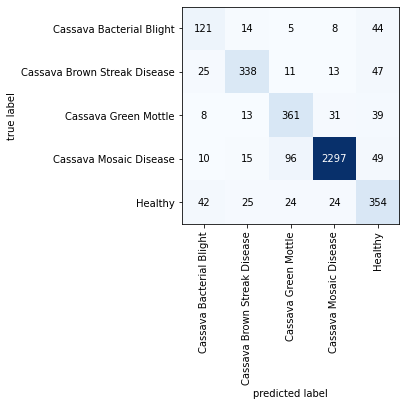

In [36]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure(figsize=(14,5))
plot_confusion_matrix(conf_mat,class_names=CLASSES)
plt.xticks(rotation = 90)